# Que buscamos:
 ---
  - Lo que buscamos es encontrar algún (o algunos) modelos que nos permitan aproximar alguna de las columnas del dataset (si, alguna).
  - Si o si tenemos que hacerlo co nla columna "precio", pero además tenemos que elgir otra (está en el enunciado).
    
  - Separemos los tantos:
       - Feature Engeniere es algo que vamos a hacer POR FUERA de todo lo que es la ejecución, es decir, cuando nosotros hagamos fit + predict + loquesea, esta nueva columna no tiene idea de que es nueva, asi que esto no nos importa tanto (para lo que es la ejecucion pura y dura)
       
       - Segmentación + K-fold + errores, es algo que nos interesa DENTRO de la ejecución.
       - Ejecutar 1 vez y tomar metricas, no estaría bueno, por lo que ya sabemos (overfitting), entonces no nos queda otra más que para cada segmento, realizar el KFold, callcular las métricas en cada Fold, y guardar el promedio de esas métricas (nos queda un array de metricas promedio en cada segmento).
       - ¿Donde empieza el prolema? En que para cada Fold, los valores de los factores de la ecuación de la recta (esos que obtenemos cuando hacemos fit) van a cambiar siempre, porque para cada "cacho" de dataset, estas cambian.
       - ¿Nos importa realmente? Obviamente googlie esto porque estaba medio perdido, y la respuesta es que no (a priori). Lo primero que a nosotros nos interesa saber, es si nuestro modelo "esta bueno", es decir, si el error total es bajo (comparando distintas métricas y demas). Esto no nos da las variables "finales", una vez que definimos que algún modelo funciona bien, recién ahí ejecutamos la regresión con TODOS los datos, y no quedamos con los factores resultantes (si usamos segmentación, seria un conjunto de factores para cada segmento, y para predecír deberíamos saber determinar a que segmento pertenece)

In [14]:
import metnum
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from Model import Model
from Segment import Segment

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df_original = pd.read_csv('../data/train.csv')
df = df_original.copy()

# Analisis de Datos
---------------------------------------------------------------------------------------
- Queremos predecir el algúna de las características de una inmueble en funcion de otras. A priori no sabemos cuales de estas características son las más representativas, ni en el conjunto de datos, ni para cualquier vivienda en particular.
- Podemos dividir a nuestras variables en 2 tipos, de tipo **numericas** y de tipo **categoricas**
- Analisemos primero las categóricas, ¿Que relación existe entre ellas?. Para cuantificar esta relación, vamos a crear una matriz de correlación. Lo que nos interesa es, entre cada par de datos, medir el coeficiente de Pearson, el cual nos permite comparar un par de variables independientemente de la escala en la que cada una se encuentre. Dado que nos interesa saber si dos variables se relacionan tanto de manera positiva como negativa, vamos a tomar el cuadrao de el coeficiente de Pearson (es la métrica conocida como R2 Score o coeficiente de determinación). Para visualizar de manera mas "amigable" estos datos, vamos a utilizar un mapa de calor.

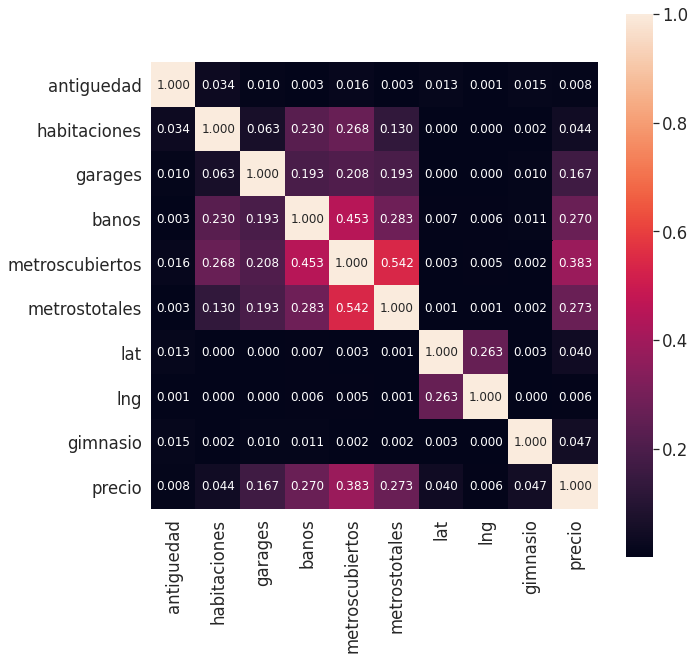

In [3]:
numeric_values = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'lat', 'lng', 'gimnasio', 'precio']
cm = np.corrcoef(df[numeric_values].dropna().values.T) **2
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.3f',
                annot_kws={'size': 12},
                yticklabels=numeric_values,
                xticklabels=numeric_values,
                ax=ax)

En el conjunto de datos utilizado existen características con valores no definidos (por ejemplo hay datos que no tienen la cantidad de baños que poseen, o no indican su antiguedad), por lo que solo tomamos el subconjunto que contenga todas las características numéricas que queremos comparar.

De manera muy rápida podemos notar que la mayoría de los datos no tienen relación entre si, lo cual tiene bastante sentido si nos lo ponemos a pensar, el hecho de que una casa tenga o no gimnasio, no nos dice nada respecto de si tiene o no piscina, o de la latitud y longitud en la que se encuentra.
Retomaremos más adelante a aquellas variables que se encuentran más relacionadas.


### Variables categoricas

Miremos un poco las variables categóricas, ¿como nos pueden ayudar en nuestra predicción?. Para contestar esta pregunta primero pensemos, ¿tiene sentido que todas las viviendas, en todo el país, tengan la misma forma de tasación?. Sabemos que en la tasaciones de inmuebles los factores de zona geografica, entre otros, se relacionan directamente con el precio final de la casa, por ejemplo no es lo mismo un inmueble con muchos metros cuadrados en una zona suburbana que en una zona rural.

Tiene sentido entonces, hablar de una **regresión segmentada**, en donde un segmento será un subconjunto de datos que corresponda a algúna de las categorias de una variable segmentada. Por ejemplo, podemos tomar subconjuntos correspondientes a los datos de cada provincia.f

---

# Predicción de Precios

Intentaremos predecir el precio de un inmueble en función de algúnas de las demás características.

## <span style="color:green"> Modelo simple con multiples variables correlacionadas, sin segmentación </span>

Empecemos armando un modelo con aquellas características que tienen mayor covarianza. Nuestro algoritmo será entrenado utilizando como features las variables
- Cantidad de baños
- Cantidad de metros cubiertos
- Cantidad de metros totales

### Hipotesis:
Previamente mencionamos la utilidad que le damos a las variables categoricas, sin embargo en este caso no vamos a aplicar segmentación. El objetivo de este experimento será demostrar que por más que exista una buena correlación entre las variables elegidas, existen factores que no necesariamente conocemos, los cuales influyen en el precio de un inmueble (que analizaremos más adelante).
Deberíamos notar un error alto en todas las métricas, por más que exista una correlación entre las variables. A la hora de predecir precios con datos que no fueron usados durante el entrenamiento, el error debería diverger. Es decir, deberíamos notar poco nivel de generalización.

In [28]:
features = ['metroscubiertos', 'metrostotales']
segment_columns = []
predict_column = 'precio'

In [29]:
# Separo en entrenamiento y testeo
df_train, df_test = train_test_split(df, test_size=0.1)
# Saco los valores que utilizo y que me dan NaN del df de testeo
df_test = df_test[features + segment_columns + [predict_column]].dropna()

model1 = Model(df_train, features, segment_columns)
segments = model1.regresionar()

In [30]:
predicts = model1.predict_rows(df_test)

In [54]:
promedio_error_generalizacion = np.abs(df_test['precio'] - predicts).mean()
promedio_error_generalizacion

982930.7167290931

In [56]:
model1.error_gral()

array([1900078352050.241, 0.3548167392677918, 0.3538523037327824,
       11094924.50139146], dtype=object)

Al entrenar el modelo nos econtramos con los siguientes errores:

Metrica | Resultado
-- | --
RMSE     | 1900078352050.241
RMSLE    | 0.3548167392677918
R2 Score | 0.3538523037327824
Max Error| 11094924.50139146 


Prestemos atención al r2 score, este valor nos indica el grado de correlación que tienen nuestras variables. 0.32 nos indica un nivel muy bajo de relación entre las variables (recordemos que el valor va entre 0 y 1). Al intentar medir el nivel de generalización tampoco nos encontramos con buenos resultados, para cada dato del conjunto de testing (un 1% del original) intentamos predecir su precio. Tomamos el promedio de el valor absoluto, de la diferencia de resultados y nos devolvió un error promedio de 982930.71. Esto sencillamente nos indica, que el modelo elegido es muy malo para la tarea que le encomendamos.

---
---

## <span style="color:green"> Modelo simple con multiples variables correlacionadas, con segmentación </span>
